## Imports

In [1]:
import fastbook
from fastbook import *
import torch
#print(torch.cuda.is_available())
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from PIL import Image
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
import random
import torchvision
import wandb
import torch.nn.functional as F
from torchinfo import summary

c:\Users\zeusg\Envs\real-fast\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


imagenet_data_test = torchvision.datasets.CIFAR10("D:\DataSets\cifar10\\train", download=False, transform=transform, train=True)
imagenet_data_val = torchvision.datasets.CIFAR10("D:\DataSets\cifar10\\val", download=False, transform=transform, train=False)

train_loader = torch.utils.data.DataLoader(imagenet_data_test, 
                                          batch_size=4,
                                          shuffle=True,
                                          
                                          )
test_loader = torch.utils.data.DataLoader(imagenet_data_val, 
                                          batch_size=4,
                                          shuffle=True,
                                          
                                          )

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([4, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


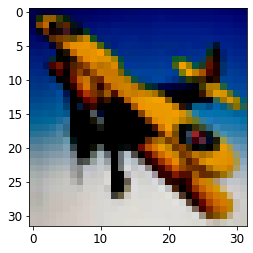

In [4]:
fig = plt.Figure()
npimg = example_data[1].numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()



In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,32,3,1,0),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,16,3,1,0),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,8,3,1,0),
            #nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(128,64),
            nn.Linear(64,32),
            nn.Linear(32,16),
            nn.Linear(16,10),
            nn.Linear(10,10),
            #nn.Softmax()
                        
        )

    def forward(self, x):
        return self.model(x)
        

In [6]:
disc = Discriminator()
out = disc(example_data)
out

tensor([[-9.1167e-02,  1.8899e-01,  1.5210e-01,  1.0296e-01,  1.1640e-01,  4.5707e-02,  4.9716e-03,  7.8158e-02, -3.0749e-01,  1.0230e-01],
        [-1.0730e-01,  1.8560e-01,  1.4021e-01,  8.8898e-02,  1.0727e-01,  2.7874e-02, -4.4953e-05,  7.0181e-02, -2.9465e-01,  9.5038e-02],
        [-9.5054e-02,  1.8922e-01,  1.5290e-01,  1.0493e-01,  1.1433e-01,  4.1451e-02,  9.4973e-03,  7.7909e-02, -3.1203e-01,  9.5646e-02],
        [-9.1707e-02,  2.1624e-01,  1.6698e-01,  8.7733e-02,  1.2491e-01,  5.4262e-02,  8.3608e-03,  6.2325e-02, -3.0269e-01,  9.5217e-02]], grad_fn=<AddmmBackward0>)

In [7]:
disc.__dict__["_modules"]['model']

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Linear(in_features=64, out_features=32, bias=True)
  (8): Linear(in_features=32, out_features=16, bias=True)
  (9): Linear(in_features=16, out_features=10, bias=True)
)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
model_stats =summary(net, verbose=1)
model_stats

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Linear: 1-4                            48,120
├─Linear: 1-5                            10,164
├─Linear: 1-6                            850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Linear: 1-4                            48,120
├─Linear: 1-5                            10,164
├─Linear: 1-6                            850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0

In [10]:
str(net)

'Net(\n  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))\n  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))\n  (fc1): Linear(in_features=400, out_features=120, bias=True)\n  (fc2): Linear(in_features=120, out_features=84, bias=True)\n  (fc3): Linear(in_features=84, out_features=10, bias=True)\n)'

In [13]:
#Hyper Params: 
wandb.init(project="wb-test")
config = wandb.config
config.learning_rate=0.001
config.momentum=.9
config.device = "cuda"
net = Discriminator().to(config.device)
model_stats = str(summary(net, verbose=0))
config.architecture =str(net)
#net = Discriminator().to(config.device)
wandb.watch(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=config.learning_rate, momentum=config.momentum)
epochs = 100
log_interval = 2000
torch.set_grad_enabled(True)
running_loss = 0.0

for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(config.device), target.to(config.device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_idx% log_interval == 0:
            rn = running_loss / 2000
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {rn / 2000:.3f}')
            
            wandb.log({"loss": loss.item()})
            wandb.log({"running loss": rn})
    with torch.no_grad():
        correct = 0
        total =0
        for (data, target) in test_loader:
            data, target = data.to(config.device), target.to(config.device)
            outputs = net(data)
            
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct +=(predicted ==target).sum().item()
        wandb.log({"Accuracy": correct/total})
            
             
    

loss,█▆▄▆▁▆▁
running loss,▁▂▄▅▆▇█
loss,0.77132
running loss,10.23413


[1,     1] loss: 0.000
[1,  2001] loss: 0.001
[1,  4001] loss: 0.002
[1,  6001] loss: 0.003
[1,  8001] loss: 0.004
[1, 10001] loss: 0.005
[1, 12001] loss: 0.005
[2,     1] loss: 0.000
[2,  2001] loss: 0.001
[2,  4001] loss: 0.001
[2,  6001] loss: 0.002
[2,  8001] loss: 0.003
[2, 10001] loss: 0.004
[2, 12001] loss: 0.004
[3,     1] loss: 0.000
[3,  2001] loss: 0.001
[3,  4001] loss: 0.001
[3,  6001] loss: 0.002
[3,  8001] loss: 0.003
[3, 10001] loss: 0.003
[3, 12001] loss: 0.004
[4,     1] loss: 0.000
[4,  2001] loss: 0.001
[4,  4001] loss: 0.001
[4,  6001] loss: 0.002
[4,  8001] loss: 0.003
[4, 10001] loss: 0.003
[4, 12001] loss: 0.004
[5,     1] loss: 0.000
[5,  2001] loss: 0.001
[5,  4001] loss: 0.001
[5,  6001] loss: 0.002
[5,  8001] loss: 0.002
[5, 10001] loss: 0.003


KeyboardInterrupt: 